In [ ]:
# This is a work in progress. Minimal implementation of synthetic data generation, 
# borrows heavily from Mujoco Colab. 


import mujoco
import mediapy as media
import time
import numpy as np
import matplotlib.pyplot as plt


import imageio_ffmpeg

!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)

""

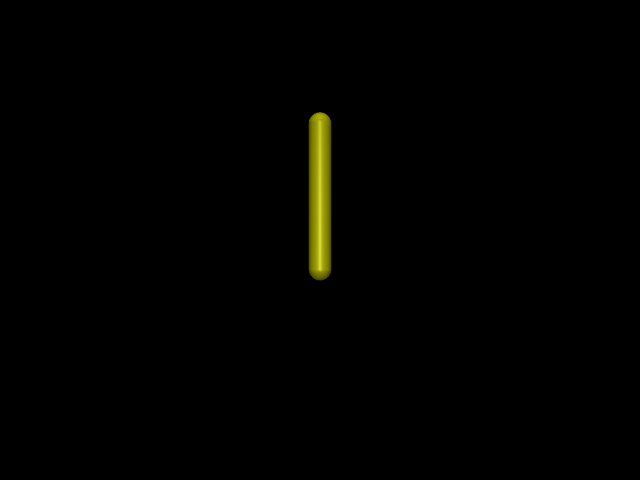

In [ ]:
# Model is hard coded version of synth_model.xml. TODO: Read from file.

chaotic_pendulum = """
<mujoco>
  <option timestep=".001">
  </option>

  <default>
    <joint type="hinge" axis="0 -1 0"/>
    <geom type="capsule" size=".02"/>
  </default>

  <worldbody>
    <light pos="0 -.4 1"/>
    <camera name="fixed" pos="0 -1 0" xyaxes="1 0 0 0 0 1"/>
    <body name="base" pos="0 0 .2">
      <joint type="free" name="root"/>
      <geom fromto="0 0 0 0 0 -.25" rgba="1 1 0 1"/>
    </body>
  </worldbody>
</mujoco>
"""

model = mujoco.MjModel.from_xml_string(chaotic_pendulum)
data = mujoco.MjData(model)
height = 480
width = 640

with mujoco.Renderer(model, height, width) as renderer:
  mujoco.mj_forward(model, data)
  renderer.update_scene(data, camera="fixed")

  media.show_image(renderer.render())

In [7]:
# setup
n_seconds = 6
framerate = 30  # Hz
n_frames = int(n_seconds * framerate)
frames = []
height = 240
width = 320

# set initial state
mujoco.mj_resetData(model, data)
data.joint('root').qvel = 2

# simulate and record frames
frame = 0
sim_time = 0
render_time = 0
n_steps = 0
with mujoco.Renderer(model, height, width) as renderer:
  for i in range(n_frames):
    while data.time * framerate < i:
      tic = time.time()
      mujoco.mj_step(model, data)
      sim_time += time.time() - tic
      n_steps += 1
    tic = time.time()
    renderer.update_scene(data, "fixed")
    frame = renderer.render()
    render_time += time.time() - tic
    frames.append(frame)

# print timing and play video
step_time = 1e6*sim_time/n_steps
step_fps = n_steps/sim_time
print(f'simulation: {step_time:5.3g} μs/step  ({step_fps:5.0f}Hz)')
frame_time = 1e6*render_time/n_frames
frame_fps = n_frames/render_time
print(f'rendering:  {frame_time:5.3g} μs/frame ({frame_fps:5.0f}Hz)')
print('\n')

# show video
media.show_video(frames, fps=framerate)

simulation:  2.75 μs/step  (364093Hz)
rendering:  1.96e+04 μs/frame (   51Hz)




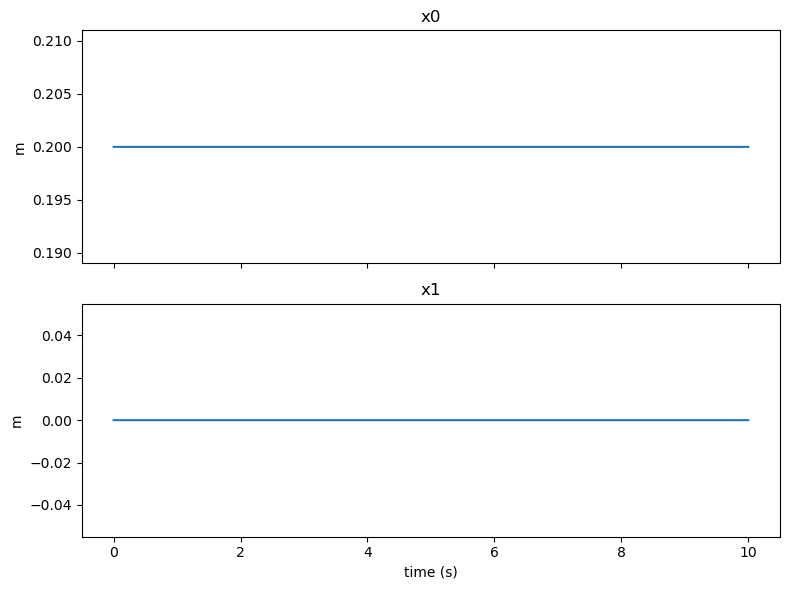

In [9]:
PERTURBATION = 1e-7
SIM_DURATION = 10.0 # seconds

# preallocate
n_steps = int(SIM_DURATION / model.opt.timestep)
sim_time = np.zeros(n_steps)
x0 = np.zeros((n_steps, 3))
x1 = np.zeros((n_steps, 3))

# prepare plotting axes
_, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# initialize
mujoco.mj_resetData(model, data)
data.qvel[0] = 10 # root joint velocity
# perturb initial velocities
#data.qvel[:] += PERTURBATION * np.random.randn(model.nv)

# simulate
for i in range(n_steps):
  mujoco.mj_step(model, data)
  sim_time[i] = data.time
  #angle[i] = data.joint('root').qpos
  x0[i] = data.body('0').xpos
  #x1[i] = data.body('1').xpos
  #print(data.body('1').xpos[0])

# plot
ax[0].plot(sim_time, x0[:,2])
ax[1].plot(sim_time, x1[:,2])

# finalize plot
ax[0].set_title('x0')
ax[0].set_ylabel('m')
ax[1].set_title('x1')
ax[1].set_ylabel('m')
ax[1].set_xlabel('time (s)')
plt.tight_layout()